In [1]:
import numpy as np
import numpy.matlib as ml
import matplotlib.pyplot as plt
import math
from IPython.display import display, Math, Latex
from IPython.display import Markdown as md
from arr2ltx import convert2latex, to_latex

import estimator as e
import math

In [2]:
T = 0.2
process_var = 1.

R = np.diag([1e-6, 1.0])

Qp = np.diag([process_var, process_var])
G = np.array([[T**2/2, 0],
             [T, 0],
             [0, T**2/2],
             [0, T]])
Q = G@Qp@G.T


initialState = np.array([30., 1., 40., 1.])
initialState = initialState[:, np.newaxis]
max_speed = 4

In [3]:
def make_true_data(x0):
    X = np.zeros((x0.shape[0], 25))
    X[:, 0] = x0.T
    for i in range(X.shape[1]-1):
        xx = e.stateModel(np.copy(X[:, i]), T)
        X[:, i+1] = xx.flatten()
    return X

X=make_true_data(initialState)
print(X)

[[30.  30.2 30.4 30.6 30.8 31.  31.2 31.4 31.6 31.8 32.  32.2 32.4 32.6
  32.8 33.  33.2 33.4 33.6 33.8 34.  34.2 34.4 34.6 34.8 35.  35.2 35.4
  35.6 35.8 36.  36.2 36.4 36.6 36.8 37.  37.2 37.4 37.6 37.8 38.  38.2
  38.4 38.6 38.8 39.  39.2 39.4 39.6 39.8 40.  40.2 40.4 40.6 40.8 41.
  41.2 41.4 41.6 41.8 42.  42.2 42.4 42.6 42.8 43.  43.2 43.4 43.6 43.8
  44.  44.2 44.4 44.6 44.8 45.  45.2 45.4 45.6 45.8 46.  46.2 46.4 46.6
  46.8 47.  47.2 47.4 47.6 47.8 48.  48.2 48.4 48.6 48.8 49.  49.2 49.4
  49.6 49.8]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   

In [4]:
def add_process_noise(X, Var):
    Xn = X + np.sqrt(Var) @ np.random.normal(loc=0, scale=1.0, size=(X.shape[0], X.shape[1]))
    return Xn
Xn = add_process_noise(X, Q)

In [5]:
def make_meas(X, R):
    Z = np.zeros((R.shape[0], X.shape[1]))
    for i in range(Z.shape[1]):
        zz = e.measureModel(np.copy(X[:, i]))
        Z[:, i] = zz.flatten()
    Zn = Z + np.sqrt(R) @ np.random.normal(loc=0, scale=math.sqrt(1.0), size=(Z.shape[0], Z.shape[1]))
    return Zn
Zn = make_meas(Xn, R)
print(Zn)

[[ 0.92719599  0.92595592  0.92712843  0.92547767  0.92296118  0.92367662
   0.91999461  0.92458352  0.91829873  0.92177447  0.91789208  0.91992435
   0.91930758  0.91841363  0.91433896  0.91803898  0.91323203  0.91325372
   0.91324767  0.91269603  0.91151845  0.91320258  0.91420096  0.91219906
   0.90902459  0.90749721  0.90827727  0.90510119  0.90786181  0.9063797
   0.90792544  0.90437342  0.90413575  0.90522748  0.905203    0.90248137
   0.90343379  0.90356537  0.90321824  0.90111639  0.90101618  0.90146048
   0.90032245  0.9008346   0.8995923   0.89692279  0.89956885  0.89570211
   0.89593725  0.89574683  0.89720535  0.89549793  0.89318946  0.89352609
   0.89726362  0.89271238  0.89419101  0.89287637  0.89427387  0.89539073
   0.89281856  0.89061309  0.89085414  0.8876871   0.88864194  0.88870898
   0.88848632  0.88959814  0.88652762  0.88745879  0.88742338  0.88685972
   0.88651056  0.88476031  0.88770892  0.88472389  0.8838688   0.88559528
   0.88378402  0.88288146  0.88257229  

In [6]:
def rot_z(a):
    a = np.deg2rad(a)
    R = np.eye(3)
    ca = np.cos(a)
    sa = np.sin(a)
    R[0,0] = ca
    R[0,1] = -sa
    R[1,0] = sa
    R[1,1] = ca
    return R

def rot_y(a):
    a = np.deg2rad(a)
    R = np.eye(3,3)
    ca = np.cos(a)
    sa = np.sin(a)
    R[0,0] = ca
    R[0,2] = sa
    R[2,0] = -sa
    R[2,2] = ca
    return R

In [7]:
def sph2cart(measurement):
    cart = np.zeros(measurement.shape)
    for i in range(measurement.shape[1]):
        cart[0, i] = measurement[1, i] * math.cos(measurement[0, i])
        cart[1, i] = measurement[1, i] * math.sin(measurement[0, i])
    return cart

cart = sph2cart(Zn)
print(cart)


def sph2cartcov(sphCov, az, el, r):
    pa = 0
    pe = 1
    pr = 2
    pvr= 3

    azSig  = np.sqrt(sphCov[pa, pa])
    elSig  = np.sqrt(sphCov[pe, pe])
    rngSig = np.sqrt(sphCov[pr, pr])

    Rpos = np.diag([np.power(rngSig,2.0),
                    np.power(r*np.cos(np.deg2rad(el))*np.deg2rad(azSig), 2.0),
                    np.power(r*np.deg2rad(elSig), 2.0)])
    rot = rot_z(az)@rot_y(el).T
    posCov = rot@Rpos@rot.T
    if sphCov.shape==(4, 4):
        rrSig = np.sqrt(sphCov[pvr, pvr])
        crossVelSig = 10
        Rvel = np.diag([np.power(rrSig, 2.0), np.power(crossVelSig, 2.0), np.power(crossVelSig, 2.0)]);
        velCov = rot@Rvel@rot.T
    else:
        velCov = 100*np.eye(3)
        
    return posCov, velCov


def make_cartcov(meas, covMeas):
    #print(meas)
    #print(covMeas)
    az = np.rad2deg(meas[0,0])
    el = 0
    r  = meas[1,0]
    sphCov = np.diag([covMeas[0,0], 0, covMeas[1,1]])
    [posCov, velCov] = sph2cartcov(sphCov, az, el, r)
    posCov = posCov[0:2,0:2]
    velCov = velCov[0:2,0:2]
    Hp = np.array([[1, 0, 0, 0],
                   [0, 0, 1, 0]])
    Hv = np.array([[0, 1, 0, 0],
                   [0, 0, 0, 1]])
    return Hp.T@posCov@Hp + Hv.T@velCov@Hv


def make_kalman_filter(measurement):
    Hp = np.array([[1, 0, 0, 0],
                   [0, 0, 1, 0]])
    x0 = sph2cart(measurement)
    x0 = Hp.T@x0
    P0  = make_cartcov(measurement, R)
    kf = e.Ekf(x0, P0, Q, R)
    return kf

[[29.66315779 31.70887487 31.22830337 30.69491492 29.58945576 31.83784808
  30.30827436 31.28816753 32.34893757 31.91960802 31.6797619  31.05838833
  32.29310223 31.70774035 32.21091833 34.1300303  33.43735885 33.6373566
  32.95251812 34.18535602 34.43244915 33.50910349 33.8765401  33.88642758
  36.2717998  35.75252546 34.62287466 35.23547093 35.351684   36.24455505
  35.76266676 37.32877004 36.84033351 36.38975275 36.56748744 36.7746023
  37.69589576 37.18028436 37.62546774 37.7350672  38.41602326 38.61611517
  38.42217531 39.15759949 40.42891401 39.34408007 39.24674883 38.96425141
  39.2265663  40.34254115 39.1778067  39.09372733 41.511131   41.65796761
  40.71400352 41.07703696 40.65485897 42.76302626 42.85881117 42.06162858
  43.07891289 42.55482146 43.65297677 42.60884068 42.88573876 41.69967138
  43.11983365 43.59912815 42.36446431 43.49072445 44.31317319 44.712139
  44.08081234 43.97748735 44.83991764 45.80445815 45.71120492 44.64876654
  45.59086505 46.3971523  47.46542325 46.6

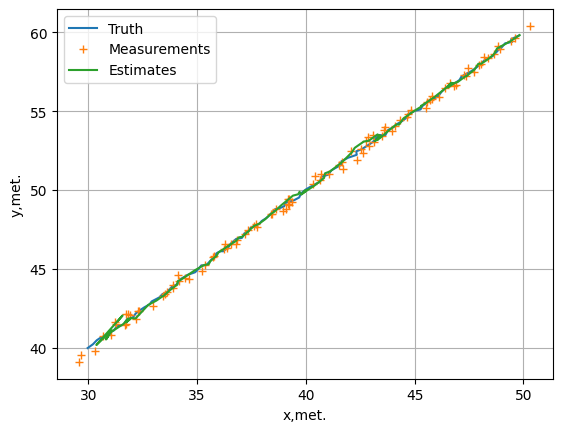

In [8]:
def step(Z, make_estimator):
    estimator = make_estimator(Z[:, 0][:, np.newaxis])
    est = np.zeros((initialState.shape[0], Z.shape[1]-1))

    for col in range(est.shape[1]):
        z = Z[:, col + 1]
        xp, _ = estimator.predictStateModel(T)
        m1 = np.array([z[0], z[1]])
        xc, _ = estimator.correctMeasureModel(m1.T)
        est[:, col] = np.squeeze(xc[:])

    return est

est=step(Zn, make_kalman_filter)

plt.figure()
plt.plot(Xn[0, :], Xn[2, :], label='Truth')
plt.plot(cart[0, :], cart[1, :], label='Measurements', linestyle='', marker='+')
plt.plot(est[0, :], est[2, :], label='Estimates')
plt.xlabel('x,met.')
plt.ylabel('y,met.')
plt.grid(True)
plt.legend()
plt.show()

100%|██████████| 2000/2000 [00:07<00:00, 283.44it/s]


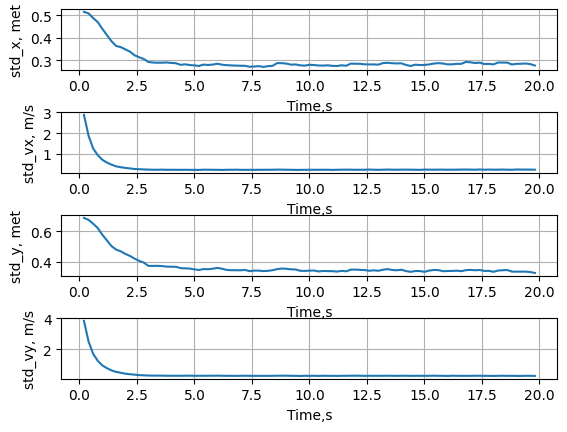

In [9]:
def calc_err(X, make_estimator):
    Xn = add_process_noise(X, Q)
    Zn = make_meas(Xn, R)
    est = step(Zn, make_estimator)
    err = est - Xn[:, 1:]
    return err

from tqdm import tqdm

def calc_std_err(X, make_estimator):
    num_iterations = 2000
    var_err = np.zeros((X.shape[0], X.shape[1]-1))

    for i in tqdm(range(num_iterations)):
        err = calc_err(X, make_estimator)
        var_err += err ** 2

    var_err /= num_iterations
    return np.sqrt(var_err)

std_err = calc_std_err(X, make_kalman_filter)

plt.figure()
plt.subplot(4, 1, 1)
plt.plot((np.arange(len(std_err[0, :]))+1)*T, std_err[0, :].T)
plt.xlabel('Time,s')
plt.ylabel('std_x, met')
plt.grid(True)
plt.subplot(4, 1, 2)
plt.plot((np.arange(len(std_err[1, :]))+1)*T, std_err[1, :].T)
plt.grid(True)
plt.xlabel('Time,s')
plt.ylabel('std_vx, m/s')
plt.subplot(4, 1, 3)
plt.plot((np.arange(len(std_err[2, :]))+1)*T, std_err[2, :].T)
plt.grid(True)
plt.xlabel('Time,s')
plt.ylabel('std_y, met')
plt.subplot(4, 1, 4)
plt.plot((np.arange(len(std_err[3, :]))+1)*T, std_err[3, :].T)
plt.grid(True)
plt.xlabel('Time,s')
plt.ylabel('std_vy, m/s')
plt.subplots_adjust(wspace=8.0, hspace=0.7)
plt.show()